In [1]:
using JuMP
using Gurobi, Ipopt
using Plots
using DataFrames
using CSV
using DelimitedFiles

In [2]:
function bicycle_model(state, input, dt, L)
    x, y, psi, v = state
    delta, a = input

    x_new = x + v * cos(psi) * dt
    y_new = y + v * sin(psi) * dt
    psi_new = psi + (v * tan(delta) / L) * dt
    v_new = v + a * dt

    return [x_new, y_new, psi_new, v_new]
end


bicycle_model (generic function with 1 method)

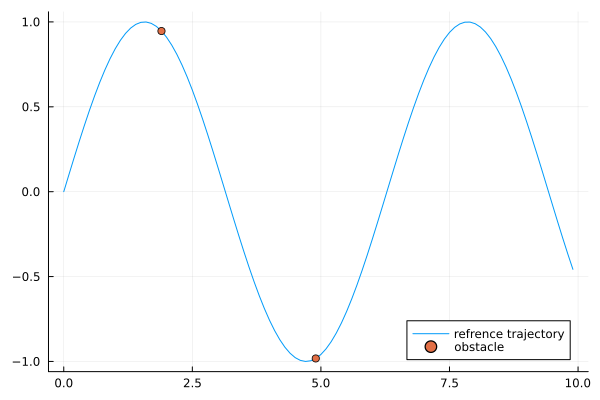

In [362]:
function reference_trajectory_gen(t)
    r = 2
    x_ref = t
    y_ref = sin(t)
    psi_ref = atan(cos(t))
    v_ref = 1.0
    return [x_ref, y_ref, psi_ref, v_ref]
end

len = 200
t = range(0,step=0.1,length=len)
ref_traj = Matrix{Float64}(undef, len,4)
for (i,t) in enumerate(t)
    ref_traj[i,:] = reference_trajectory_gen(t)
end
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = len
obstacles = []
plot(ref_x[1:100],ref_y[1:100], label="refrence trajectory")

obstacles = [ref_x[50] ref_y[50] 0.2;
             ref_x[20] ref_y[20] 0.2]
scatter!(obstacles[:,1], obstacles[:,2] ,label="obstacle")

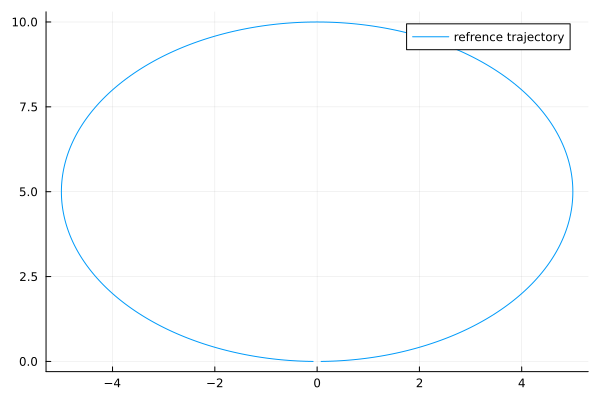

In [338]:
data = DataFrame(CSV.File("Circle_Traj_CW.csv"))
ref_traj = Matrix(data)
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = size(data)[1]
obstacles = []
plot(ref_x,ref_y, label="refrence trajectory")

# obstacles = [ref_x[50] ref_y[50] 1]
# scatter!(obstacles[:,1], obstacles[:,2] ,label="obstacle")

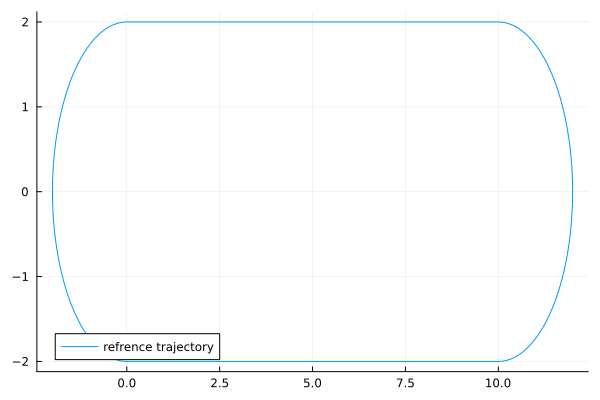

In [353]:
data = DataFrame(CSV.File("input_trajectory.csv"))
ref_traj = Matrix(data)
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]

N = size(data)[1]
#ref_psi = ref_traj[:,3]
ref_v = ones(N)
ref_psi = zeros(N)
for i in 1:N-1
    ref_psi[i] = pi + atan(ref_y[i+1]-ref_y[i], ref_x[i+1]-ref_x[i])  
end
ref_traj = hcat(ref_traj,ref_psi,ref_v)
obstacles = []

plot(ref_x,ref_y, label="refrence trajectory")

# obstacles = [ref_x[50] ref_y[50] 1]
# scatter!(obstacles[:,1], obstacles[:,2] ,label="obstacle")

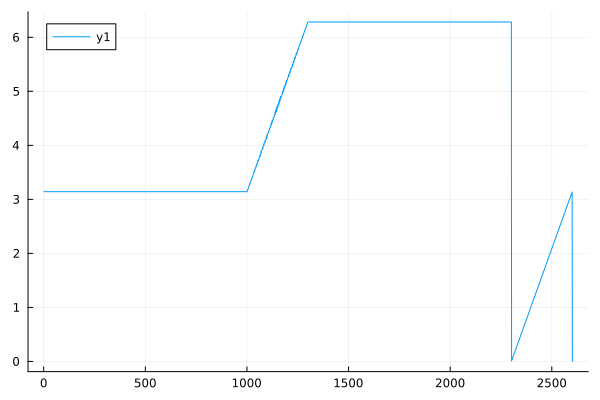

In [350]:
plot(1:N, ref_psi)

In [236]:
for (i,y) in enumerate(ref_y)
    if abs(y) < 0.1
        println(i)
    end
end

105
209
210


In [234]:
ref_y[210]

0.08406950242

In [320]:
function mpc_solver(state, T, dt, L, Q, R, step, u_prev, reference_trajectory, obstacles)
    
#     if step+T > size(reference_trajectory)[1]
#         T = size(reference_trajectory)[1] - step + 1
#         println("HELLO ", step, " ", T)
#     end
    
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, x[1:T+1])
    @variable(model, y[1:T+1])
    @variable(model, psi[1:T+1])
    @variable(model, v[1:T+1])
    @variable(model, delta[1:T])
    @variable(model, a[1:T])
    
    # warm start up from previous output
    set_start_value(delta[1], u_prev[1])
    set_start_value(a[1], u_prev[2])

    #closest_refs = [find_closest_ref(x[i],y[i]) for i in 1:N]
   
    #idx = (step+i-1)%N
    @NLexpression(model, err, sum( (Q[1]*(x[i] - reference_trajectory[(step+i-1)%N + 1,1])^2 + Q[2]*(y[i] - reference_trajectory[(step+i-1)%N + 1,2])^2
                    + Q[3]*(psi[i] - reference_trajectory[(step+i-1)%N + 1,3])^2 + Q[4]*(v[i] - reference_trajectory[(step+i-1)%N + 1,4]))^2 for i in 1:T))

    @NLexpression(model, input, sum( (R[1]*delta[i]^2 + R[2]*a[i]^2) for i in 1:T))

    @NLobjective(model, Min, err + input)

    # Bicycle model constraint
    for i in 1:T-1
        @NLconstraint(model, x[i+1] == x[i] + v[i] * cos(psi[i]) * dt) 
        @NLconstraint(model, y[i+1] == y[i] + v[i] * sin(psi[i]) * dt)  
        @NLconstraint(model, psi[i+1] == psi[i] + (v[i] * tan(delta[i]) / L) * dt)
        @constraint(model, v[i+1] ==  v[i] + a[i]*dt)
        #@constraint(model, v[i+1] ==  1)
    end

    #@constraint(model, vel[i in 1:N], v)
    
    # set initial constraint
    @constraint(model, x[1]   == state[1])
    @constraint(model, y[1]   == state[2])
    @constraint(model, psi[1] == state[3])
    @constraint(model, v[1]   == state[4])
    
    # control input constraints
    @constraint(model, a_up[i in 1:T], a[i] <= 0.2)
    @constraint(model, a_lb[i in 1:T], a[i] >= -0.2)
    
    @constraint(model, delta_up[i in 1:T], delta[i] <= pi/6)
    @constraint(model, delta_lb[i in 1:T], delta[i] >= -pi/6)
    
    # obstacle constraint
    num_obstacles = size(obstacles)[1] 
    if num_obstacles > 0
        for o in 1:num_obstacles
            #@NLconstraint(model, obs_constr[i in 1:T], (x[i] - obstacles[o,1])^2 + (y[i]-obstacles[o,2])^2 >= obstacles[o,3]^2)
           for i in 1
                @NLconstraint(model, (x[i] - obstacles[o,1])^2 + (y[i]-obstacles[o,2])^2 >= obstacles[o,3]^2)
            end
        end
    end

    optimize!(model)
    return value.(delta[1]), value.(a[1]), objective_value(model)
end

mpc_solver (generic function with 1 method)

In [363]:
T = 50
dt = 0.1
L = 0.1
Q = [10.0, 10.0, 1.0, 1.0]
R = [0.1, 0.1]
initial_state = [0.0, 0.0, 0, 1.0]
num_steps = 100

state = initial_state
state_mat =  Matrix{Float64}(undef, num_steps,4)
control_mat =  Matrix{Float64}(undef, num_steps,2)
err_vec = []
delta_prev = 0
a_prev = 0
for step in 1:num_steps
    t = step * dt
    delta, a, err = mpc_solver(state, T, dt, L, Q, R, step, [delta_prev, a_prev], ref_traj, obstacles)
    state = bicycle_model(state, [delta, a], dt, L)
    state_mat[step,:] = state
    control_mat[step,:] = [delta, a]
    append!(err_vec, err)
    delta_prev = delta
    a_prev = a
    println("Step: ", step, ", State: ", state, ", Control Input: (", delta, ", ", a, ")")
    #break
end


Step: 1, State: [0.1, 0.0, 0.5773502059788855, 1.0199999978307048], Control Input: (0.5235987281902424, 0.1999999783070475)
Step: 2, State: [0.18546700976220057, 0.055672167175836555, 0.8032405849748709, 1.0399999949088135], Control Input: (0.21794357808766263, 0.19999997078108722)
Step: 3, State: [0.25768236320154436, 0.13051161280268478, 0.7896799293765215, 1.0599999822149002], Control Input: (-0.01303835310092854, 0.1999998730608674)
Step: 4, State: [0.3323140620872421, 0.20578517485730277, 0.7709756697914847, 1.079999976777276], Control Input: (-0.017643697150542332, 0.19999994562375986)
Step: 5, State: [0.4097750224502644, 0.2810433911398288, 0.748183134826558, 1.0999999692121833], Control Input: (-0.021101067152050415, 0.19999992434907332)
Step: 6, State: [0.4903968918828535, 0.35587729717086936, 0.7206718269211739, 1.119999937809432], Control Input: (-0.025005067808906767, 0.19999968597248713)
Step: 7, State: [0.5745494947293075, 0.42978492898990617, 0.687663154071461, 1.1399999

Step: 53, State: [5.204479681093891, -0.5409573839529513, 0.2548993153367301, 1.1252446265900384], Control Input: (-0.11147799240655946, 0.1999991519552347)
Step: 54, State: [5.313368330735411, -0.5125845681613583, 0.3357355025109705, 1.1452445289961137], Control Input: (0.0717155667805233, 0.1999990240607531)
Step: 55, State: [5.42149868228559, -0.4748529185076529, 0.4057010413148693, 1.165244415736799], Control Input: (0.06101639277766807, 0.19999886740685235)
Step: 56, State: [5.52856436276898, -0.42886503372604085, 0.4639756449624196, 1.1852442827051533], Control Input: (0.04996899605097627, 0.19999866968354324)
Step: 57, State: [5.634558440720851, -0.3758245252821635, 0.5125940659733779, 1.2052441240030556], Control Input: (0.04099676365977481, 0.19999841297902393)
Step: 58, State: [5.739592478165532, -0.3167145856568489, 0.5535876767897776, 1.2252439309509935], Control Input: (0.03399959639146412, 0.19999806947937807)
Step: 59, State: [5.843817094314944, -0.2522983121552699, 0.58

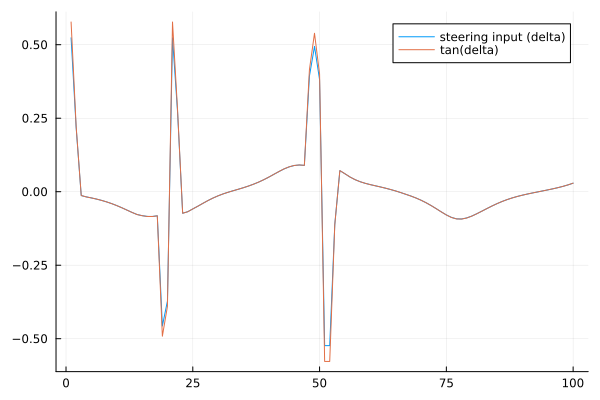

In [364]:
plot(1:num_steps, [control_mat[:,1], tan.(control_mat[:,1])], label=["steering input (delta)" "tan(delta)"])

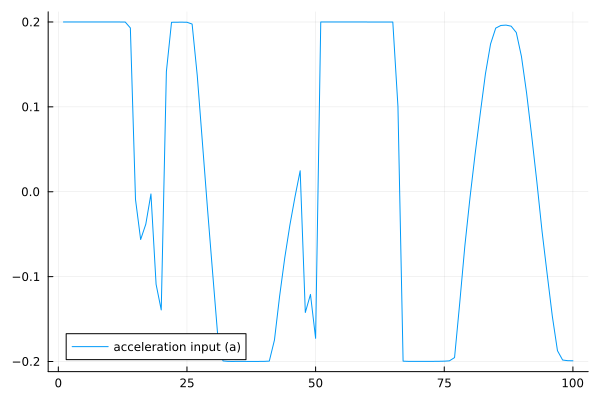

In [365]:
plot(1:num_steps, control_mat[:,2], label="acceleration input (a)")

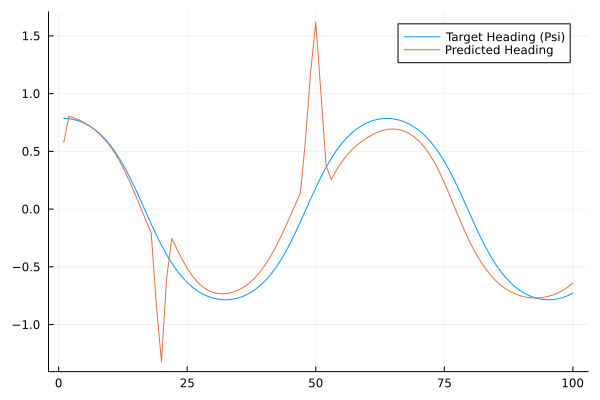

In [366]:
plot(1:num_steps, [ref_psi[1:num_steps],state_mat[:,3]], label=["Target Heading (Psi)" "Predicted Heading"])

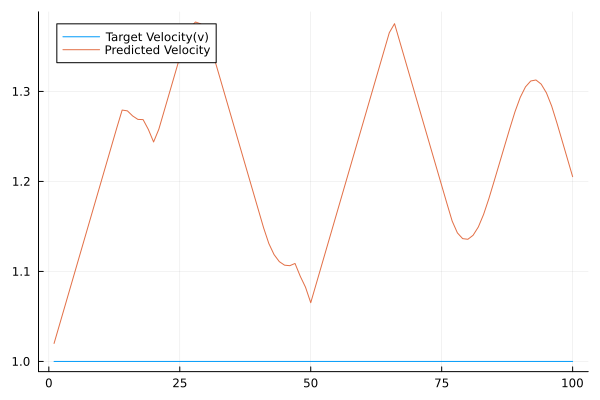

In [367]:
plot(1:num_steps, [ref_v[1:num_steps],state_mat[:,4]], label=["Target Velocity(v)" "Predicted Velocity"])

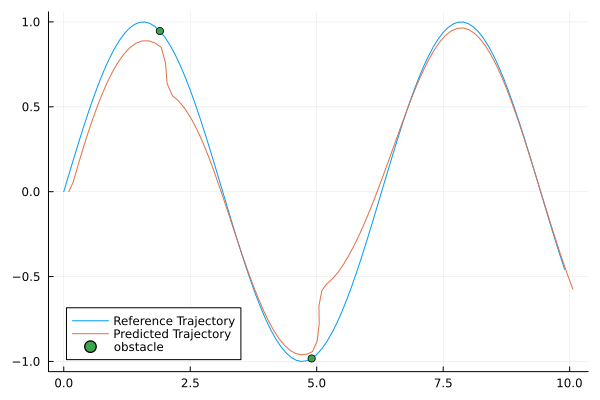

In [370]:
x = state_mat[:,1]
y = state_mat[:,2]
plot(ref_x[1:num_steps], ref_y[1:num_steps], label="Reference Trajectory")
plot!(x,y, label="Predicted Trajectory")
scatter!(obstacles[:,1], obstacles[:,2],label="obstacle")

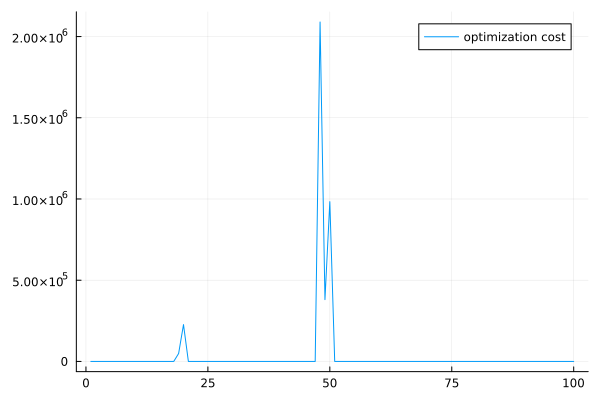

In [371]:
plot(1:num_steps, err_vec, label = "optimization cost")

In [27]:
ref_x

1000-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 9.88
 9.89
 9.9
 9.91
 9.92
 9.93
 9.94
 9.95
 9.96
 9.97
 9.98
 9.99

In [86]:
400*0.01

4.0